# Frequency Spectrum Distribution Similarity (FSDS)
FSDS describes the image quality from the perspective of frequency spectrum. The complete implementation of FSDS is in `FSDS_code.py`. This jupyter notebook file is to explain how the code runs. A minimal example is shown below:

In [2]:
import FSDS_code
from PIL import Image
from torchvision.transforms import ToTensor
sr = ToTensor()(Image.open("./example_figures/EDSRx4.png"))
gt = ToTensor()(Image.open("./example_figures/gt.png"))
fsds = FSDS_code.FrequencySpectrumDistributionSimilarity(sr, gt)
print(f"The fsds metric of the example image is {fsds:.3f}")

The fsds metric of the example image is 29.056


## Entrance of FSDS metric
In `FSDS_code.py`, you can find a function named `FrequencySpectrumDistributionSimilarity(pred, gt)`. This function takes two arguments, `pred` and `gt`, which are the predicted image and the ground truth image, respectively. The function returns a scalar value, which is the FSDS score of the predicted image. `pred` or `gt` can be pytorch tensor of shape `NxCxHxW` or `CxHxW`, `N` is the batch size, `C` is the number of channels, `H` and `W` is the spatial sieze of the image. The function will return a scalar value if the tensor is in shape `CxHxW`, otherwise it will return a list of scalar values.
The implementation of `FrequencySpectrumDistributionSimilarity` is shown below.
```python
def FrequencySpectrumDistributionSimilarity(pred, gt):
    if pred.shape != gt.shape:
        raise ValueError("The shape of input tensor does not match")
    if len(pred.shape) == 3:
        return _FrequencySpectrumDistributionSimilarity(pred, gt)
    elif len(pred.shape) == 4:
        index = []
        for i in range(pred.shape[0]):
            index.append(_FrequencySpectrumDistributionSimilarity(pred[i], gt[i]))
        return index

```
`_FrequencySpectrumDistributionSimilarity` is the actual function to calculate FSDS index.

## Implementation of FSDS
### 1) `torch.fft.fft2` or `torch.fft.rfft2` ?
According to the PyTorch official document, we know that the FFT of a real signal is Hermitian-symmetric, X[i, j] = conj(X[-i, -j]), so the full fft2() output contains redundant information. rfft2() instead omits the negative frequencies in the last dimension. In other words, for an input of size (N, C, H, W), fft2() returns an output complex tensor of size (N,C,H,W) while rfft2() returns an output complex tensor of size (N, C, H/2, W). This figure intuitively shows the difference between `fft2()` and `rfft2()`.
 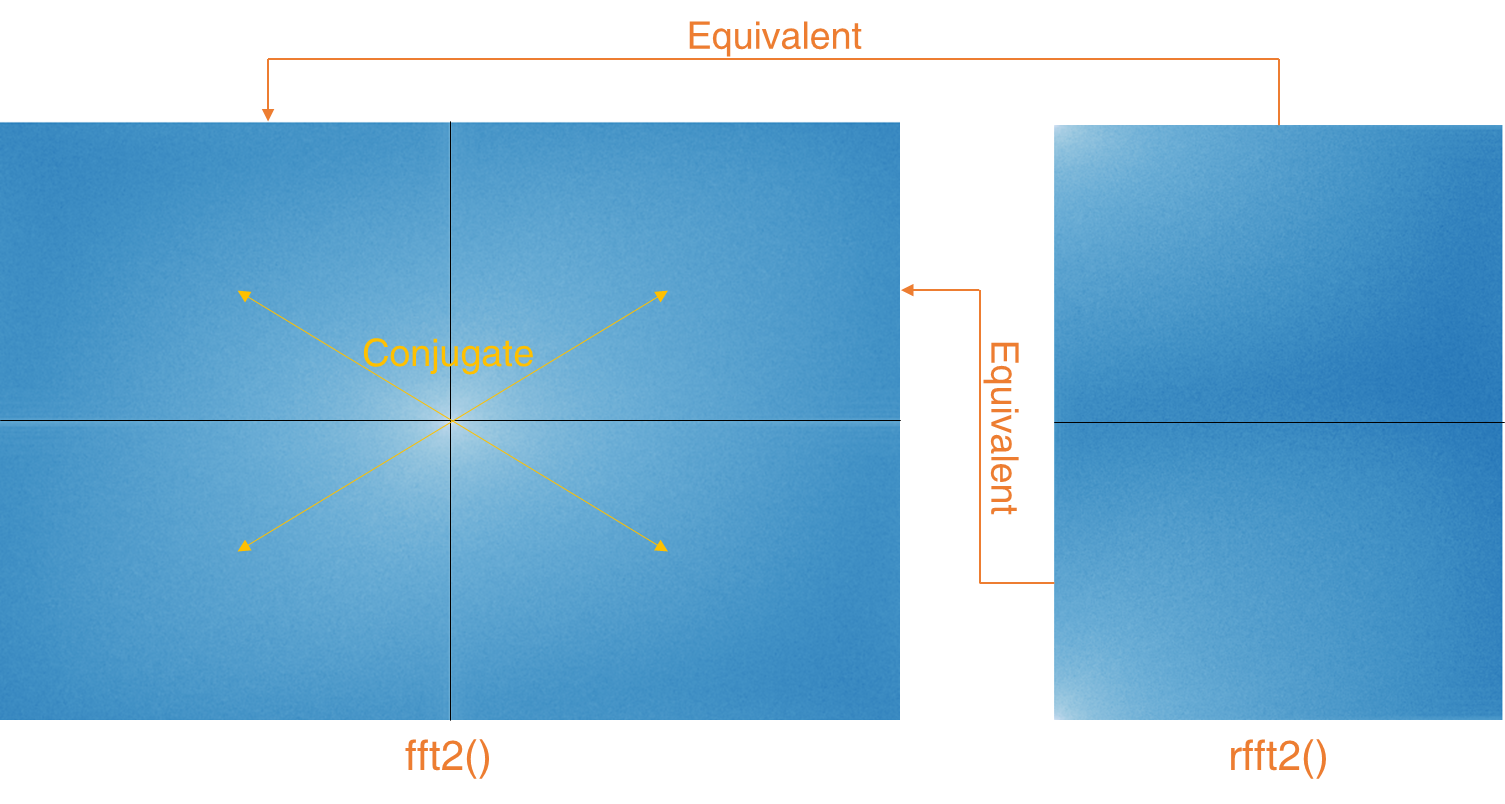

To reduce redunant information, different from the description in paper, we utilize `torch.fft.rfft2` rather than `torch.fft.fft2` in acutal code.

### 2) Alignment and Integration
In actual implementation, we first spilit frequency spectrum provided by `torch.fft.rfft2` into two part. To avoid an odd height, we first pad zero to make the image even height before `torch.fft.rfft2`. Then we apply `torch.cumsum` respectively to the spatial dimesnions to obtain the integrated frequency spectrum. The code implementation is:
 ```python
def frequency_align_integrate(tsr):
    """
    :param tsr: CxHxW
    :return:
    """
    # pad zeros to make  even
    if tsr.shape[1] % 2 == 1:
        tsr = torch.concat([tsr, torch.zeros(tsr.shape[0], 1, tsr.shape[2])], dim=1)

    tsr_rfft = torch.fft.rfft2(tsr, norm="backward")
    part_1 = einops.rearrange(tsr_rfft, "C (p H) W -> C p H W", p=2)
    part_2 = part_1[:, 1, :, :]  # C H/2 W
    part_1 = part_1[:, 0, :, :]  # C H/2 W
    part_2 = torch.flip(part_2, dims=[1]).contiguous()

    part_1 = torch.cumsum(part_1, dim=1)
    part_1 = torch.cumsum(part_1, dim=2)

    part_2 = torch.cumsum(part_2, dim=1)
    part_2 = torch.cumsum(part_2, dim=2)

     # the final integrated frequency spectrum of the two pars.retur
```
### 3) Calculating FSDS
The implementation of FSDS is in `_FrequencySpectrumDistributionSimilarity`. This function first normailize the two input tensor and then calculate the integrated frequency spectrum using `frequency_align_integrate)`. Finally, the FSDS index is obtained by:
$$
\operatorname{FSDS}=-10\log_{10}\frac{\iint_{(\omega_1, \omega_2)\in \mathbb{R}^2}|D^\mathrm{diff}|^2\mathrm{d}\omega_1\mathrm{d}\omega_2}{\iint_{(\omega_1, \omega_2)\in \mathbb{R}^2}|D^\mathrm{SR}|^2\mathrm{d}\omega_1\mathrm{d}\omega_2}
$$
The code implementation is:
```python
def _FrequencySpectrumDistributionSimilarity(pred, tar):
    """

    :param pred: the predicted output, in shape CxHxW
    :param tar: the ground-truth data, in shape CxHxW
    :return:
    """
    if pred.shape != tar.shape:
        raise ValueError("The shape of pred is expected to be the same as tar")

    pred = pred - torch.mean(pred)
    pred /= torch.std(pred)
    tar = tar - torch.mean(tar)
    tar /= torch.std(tar)

    pred_part_1, pred_part_2 = frequency_align_integrate(pred)  # C H/2 W
    tar_part_1, tar_part_2 = frequency_align_integrate(tar)  # C H/2 W

    part_1_error = ((pred_part_1 - tar_part_1).abs()) ** 2
    part_2_error = ((pred_part_2 - tar_part_2).abs()) ** 2

    return -10*math.log10(torch.sum(part_1_error + part_2_error) / torch.sum(tar_part_2.abs() ** 2 + tar_part_1.abs() ** 2))
```
